In [30]:
# Lab 03 (2 hrs) – Encoding → Scaling → Feature Engineering → Sampling
# Learning Outcomes
# By the end of this lab, students will be able to:
# • Implement an end-to-end preprocessing pipeline in sklearn.
# • Perform feature engineering &amp; selection.
# • Save train/test splits and preprocessing artifacts.
# P — Project
# 1. Build sklearn pipeline for encoding, scaling, feature creation.
# 2. Correlation heatmap; drop redundant feature.
# 3. Stratified sampling, save splits &amp; pipeline.
# Resources
# • Sklearn Feature Selection – https://scikitlearn.
# org/stable/modules/feature_selection.html
# • Seaborn Heatmap –
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
# • Kaggle Titanic Tutorials –
# https://www.kaggle.com/competitions/titanic/tutorials

In [31]:
import json
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# -------- Config --------
INPUT_CSV = "LabAssig2_cleanTitanicCSV.csv"  
OUTPUT_DIR = Path("LabAssig3_stuff")
TARGET = "survived"
HIGH_CORR_THRESHOLD = 0.90

# Candidate base columns
NUM_CANDIDATES = ["pclass", "age", "sibsp", "parch"]
POSSIBLE_FARE_COLS = ["fare_capped", "fare"]  

# Drop known leaky/redundant columns
DROP_COLS = set(["alive","who","adult_male","class","embark_town"])

CAT_CANDIDATES = ["sex", "embarked", "alone", "age_was_missing"]

# Create artifacts directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Set plotting style
sns.set(context="notebook", style="whitegrid", palette="deep")


In [32]:
# Load data
df = pd.read_csv(INPUT_CSV)

# Quick peek
display(df.head())
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Basic target checks
assert TARGET in df.columns, f"Target '{TARGET}' not found in data."
assert df[TARGET].isin([0,1]).all(), "Target must be binary 0/1."


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone,age_was_missing,fare_capped
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,Southampton,no,False,0,7.2500
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,Cherbourg,yes,False,0,65.6563
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,Southampton,yes,True,0,7.9250
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,Southampton,yes,False,0,53.1000
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,Southampton,no,True,0,8.0500


Shape: (889, 16)
Columns: ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'embark_town', 'alive', 'alone', 'age_was_missing', 'fare_capped']


In [33]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df[TARGET],
    random_state=42
)

print("Train shape:", train_df.shape, "| Test shape:", test_df.shape)
train_df.to_csv(OUTPUT_DIR / "train.csv", index=False)
test_df.to_csv(OUTPUT_DIR / "test.csv", index=False)
print("Saved stratified splits to artifacts_lab03/train.csv and test.csv")


Train shape: (711, 16) | Test shape: (178, 16)
Saved stratified splits to artifacts_lab03/train.csv and test.csv


In [34]:
def add_features(df_in: pd.DataFrame) -> pd.DataFrame:
    df_out = df_in.copy()
    # family size
    df_out["family_size"] = df_out["sibsp"].fillna(0) + df_out["parch"].fillna(0) + 1
    # is_child
    df_out["is_child"] = (df_out["age"] < 16).astype(int)
    # is_female
    df_out["is_female"] = (df_out["sex"] == "female").astype(int)
    return df_out

def choose_fare_column(df_in: pd.DataFrame):
    for c in POSSIBLE_FARE_COLS:
        if c in df_in.columns:
            return c
    return None

def build_feature_lists(df_in: pd.DataFrame):
    # Drop undesired columns from consideration (not from df itself)
    kept = [c for c in df_in.columns if c not in DROP_COLS and c != TARGET]
    
    # Numeric base
    fare_col = choose_fare_column(df_in)
    num_list = [c for c in NUM_CANDIDATES if c in kept]
    if fare_col and fare_col in kept:
        num_list = num_list + [fare_col]
    
    # Engineered numeric/bin
    eng_num = ["family_size"]
    eng_bin = ["is_child", "is_female"]
    
    # Categoricals (only those present)
    cat_list = [c for c in CAT_CANDIDATES if c in kept]
    return num_list, eng_num, eng_bin, cat_list

def save_sparse_matrix(filename, X):
    if sparse.issparse(X):
        sparse.save_npz(filename, X)
    else:
        sparse.save_npz(filename, sparse.csr_matrix(X))

def save_transformed_to_csv(pipe, X, csv_path: Path):
    """
    Saves a transformed design matrix X to CSV with proper column names if available.
    Falls back to generic column names when feature names are unavailable.
    """
    try:
        feature_names = pipe.named_steps["pre"].get_feature_names_out()
    except Exception:
        feature_names = [f"f{i}" for i in range(X.shape[1])]

    # Convert sparse to dense carefully; for large matrices, prefer keeping .npz only.
    if sparse.issparse(X):
        X_dense = X.toarray()
    else:
        X_dense = np.asarray(X)

    dfX = pd.DataFrame(X_dense, columns=feature_names)
    dfX.to_csv(csv_path, index=False)


In [35]:
train_fe = add_features(train_df)
test_fe  = add_features(test_df)

num_list, eng_num, eng_bin, cat_list = build_feature_lists(train_fe)
numeric_cols_all = num_list + eng_num + eng_bin

print("Numeric (pre-drop):", numeric_cols_all)
print("Categorical:", cat_list)


Numeric (pre-drop): ['pclass', 'age', 'sibsp', 'parch', 'fare_capped', 'family_size', 'is_child', 'is_female']
Categorical: ['sex', 'embarked', 'alone', 'age_was_missing']


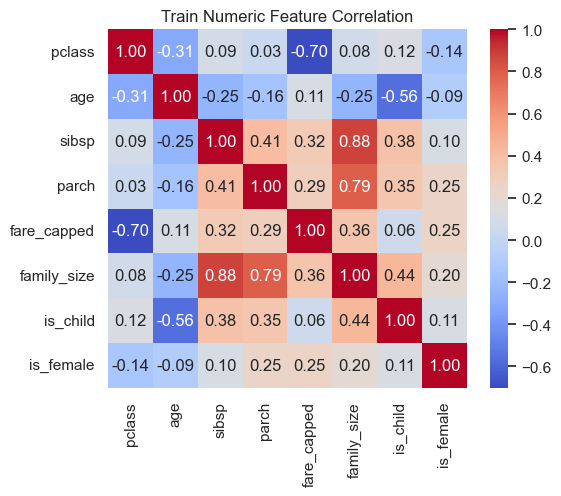

High-correlation drop list: []
Numeric (final): ['pclass', 'age', 'sibsp', 'parch', 'fare_capped', 'family_size', 'is_child', 'is_female']


In [36]:
# Compute correlation on numeric columns of train only
corr_df = train_fe[numeric_cols_all].corr(numeric_only=True)

plt.figure(figsize=(6,5))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Train Numeric Feature Correlation")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "correlation_heatmap.png", dpi=150)
plt.show()

# Identify redundant columns by absolute correlation threshold
to_drop = set()
cols = corr_df.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        cval = corr_df.iloc[i, j]
        if pd.notna(cval) and abs(cval) >= HIGH_CORR_THRESHOLD:
            # Heuristic: drop the second in the pair
            to_drop.add(cols[j])

# If both fare and fare_capped exist and both are flagged, prefer keeping fare_capped
if "fare" in to_drop and "fare_capped" in numeric_cols_all: pass

to_drop = sorted(to_drop)
print("High-correlation drop list:", to_drop)

numeric_final = [c for c in numeric_cols_all if c not in to_drop]
print("Numeric (final):", numeric_final)


In [37]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_final),
        ("cat", categorical_transformer, cat_list),
    ],
    remainder="drop",
    sparse_threshold=1.0  
)

pipe = Pipeline(steps=[
    ("pre", preprocessor)
])

print("Preprocessing pipeline ready.")


Preprocessing pipeline ready.


In [38]:
X_train = train_fe.drop(columns=[TARGET])
y_train = train_fe[TARGET].copy()

X_test = test_fe.drop(columns=[TARGET])
y_test = test_fe[TARGET].copy()

# Fit the preprocessing pipeline on TRAIN only
pipe.fit(X_train, y_train)

# Transform both splits
Xt_train = pipe.transform(X_train)
Xt_test  = pipe.transform(X_test)

# Save artifacts
joblib.dump(pipe, OUTPUT_DIR / "fitted_pipeline.pkl")

# Optional compact sparse matrices (can be omitted if CSVs only are desired)
save_sparse_matrix(OUTPUT_DIR / "X_train_transformed.npz", Xt_train)
save_sparse_matrix(OUTPUT_DIR / "X_test_transformed.npz", Xt_test)

# Human-readable CSVs of transformed data
save_transformed_to_csv(pipe, Xt_train, OUTPUT_DIR / "X_train_transformed.csv")
save_transformed_to_csv(pipe, Xt_test,  OUTPUT_DIR / "X_test_transformed.csv")

# Selected features and drops as CSV (instead of JSON)
meta_rows = []
meta_rows.append({"key": "target", "value": TARGET})
for c in numeric_final:
    meta_rows.append({"key": "numeric_final", "value": c})
for c in cat_list:
    meta_rows.append({"key": "categorical", "value": c})
for c in to_drop:
    meta_rows.append({"key": "dropped_numeric_high_corr", "value": c})

pd.DataFrame(meta_rows).to_csv(OUTPUT_DIR / "selected_features.csv", index=False)

print("Artifacts saved to:", OUTPUT_DIR.resolve())
print(" - fitted_pipeline.pkl")
print(" - X_train_transformed.npz / .csv")
print(" - X_test_transformed.npz / .csv")
print(" - selected_features.csv")
print(" - correlation_heatmap.png")
print(" - train.csv, test.csv")


Artifacts saved to: /Users/pranay/Pranay/DTU/ClassWork/SEM5/MachineLearningLab/LabAssig3_stuff
 - fitted_pipeline.pkl
 - X_train_transformed.npz / .csv
 - X_test_transformed.npz / .csv
 - selected_features.csv
 - correlation_heatmap.png
 - train.csv, test.csv


In [39]:
print("Xt_train type:", type(Xt_train))
print("Xt_test type:", type(Xt_test))
print("Xt_train shape:", Xt_train.shape)
print("Xt_test shape:", Xt_test.shape)

# Show feature names for sanity (works in recent sklearn versions)
try:
    feature_names = pipe.named_steps["pre"].get_feature_names_out()
    print("Total transformed features:", len(feature_names))
    print("Sample feature names:", feature_names[:30])
except Exception as e:
    print("Could not retrieve feature names:", e)


Xt_train type: <class 'scipy.sparse._csr.csr_matrix'>
Xt_test type: <class 'scipy.sparse._csr.csr_matrix'>
Xt_train shape: (711, 17)
Xt_test shape: (178, 17)
Total transformed features: 17
Sample feature names: ['num__pclass' 'num__age' 'num__sibsp' 'num__parch' 'num__fare_capped'
 'num__family_size' 'num__is_child' 'num__is_female' 'cat__sex_female'
 'cat__sex_male' 'cat__embarked_C' 'cat__embarked_Q' 'cat__embarked_S'
 'cat__alone_False' 'cat__alone_True' 'cat__age_was_missing_0'
 'cat__age_was_missing_1']
